In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [2]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: .\cifar10.tgz


In [3]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [6]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [8]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [9]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [10]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [12]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  airplane (0)


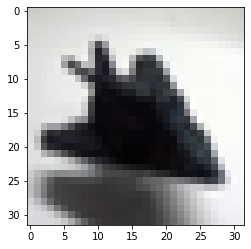

In [13]:
show_example(*dataset[0])

Label:  airplane (0)


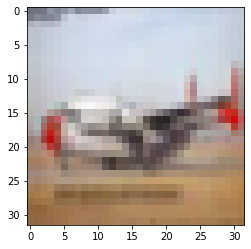

In [14]:
show_example(*dataset[1099])

# Training & Validating Dataset

In [15]:
random_seed = 42
torch.manual_seed(random_seed);

In [16]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [17]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [18]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [19]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

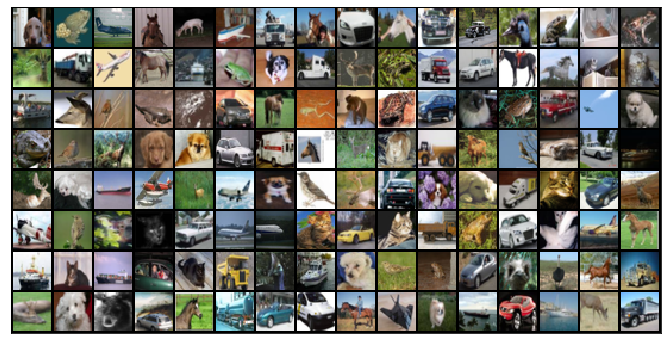

In [20]:
show_batch(train_dl)

# Defining the Model (Convolutional Neural Network)

In [21]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [22]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
## Learning
conv = nn.Conv2d(3, 8, kernel_size= 3, stride= 1, padding= 1)

In [25]:
#Learning
pool = nn.MaxPool2d(2, 2)

In [26]:
#Learning
for images, label in train_dl:
    print('images.shape', images.shape)
    out = conv(images)
    out = pool(out)
    print('out.shape', out.shape)
    break

images.shape torch.Size([128, 3, 32, 32])
out.shape torch.Size([128, 8, 16, 16])


In [27]:
#Learning
print(conv.weight.shape)
print(conv.weight[0])

torch.Size([8, 3, 3, 3])
tensor([[[-0.1398,  0.1772,  0.0425],
         [-0.0123,  0.1491, -0.0260],
         [ 0.0454,  0.1039,  0.0843]],

        [[-0.1612, -0.0831, -0.1083],
         [ 0.1363, -0.0058, -0.0148],
         [ 0.0635,  0.0091,  0.0112]],

        [[-0.0657, -0.0093,  0.1648],
         [ 0.1584, -0.0931,  0.0160],
         [ 0.1131, -0.1040,  0.0193]]], grad_fn=<SelectBackward>)


In [28]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [29]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


In [30]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
# We'll use nn.Sequential to chain the layers and activations functions into a single network architecture.
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [32]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [33]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0391, -0.0104,  0.0005,  0.0281, -0.0311, -0.0069,  0.0147, -0.0170,
         0.0353,  0.0030], grad_fn=<SelectBackward>)


In [34]:
#Setting Up GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [35]:
device = get_default_device()
device

device(type='cuda')

In [36]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Training the Data

In [37]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [38]:
# Loading Model in the GPU
model = to_device(Cifar10CnnModel(), device)

In [39]:
evaluate(model, val_dl)

{'val_loss': 2.3025383949279785, 'val_acc': 0.10006892681121826}

In [41]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

In [42]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7978, val_loss: 1.4606, val_acc: 0.4551
Epoch [1], train_loss: 1.3005, val_loss: 1.1570, val_acc: 0.5763
Epoch [2], train_loss: 1.0534, val_loss: 1.0039, val_acc: 0.6399
Epoch [3], train_loss: 0.8992, val_loss: 0.9106, val_acc: 0.6762
Epoch [4], train_loss: 0.7771, val_loss: 0.8364, val_acc: 0.7051
Epoch [5], train_loss: 0.6792, val_loss: 0.7722, val_acc: 0.7303
Epoch [6], train_loss: 0.5839, val_loss: 0.7660, val_acc: 0.7379
Epoch [7], train_loss: 0.5015, val_loss: 0.7243, val_acc: 0.7642
Epoch [8], train_loss: 0.4302, val_loss: 0.7549, val_acc: 0.7621
Epoch [9], train_loss: 0.3569, val_loss: 0.7622, val_acc: 0.7627
Epoch [10], train_loss: 0.3042, val_loss: 0.8111, val_acc: 0.7608
Epoch [11], train_loss: 0.2544, val_loss: 0.9007, val_acc: 0.7666
Epoch [12], train_loss: 0.2075, val_loss: 0.9357, val_acc: 0.7630
Epoch [13], train_loss: 0.1746, val_loss: 0.9900, val_acc: 0.7660
Epoch [14], train_loss: 0.1488, val_loss: 1.0904, val_acc: 0.7546
Epoch [15], train_lo

In [43]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.0001

In [44]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.0174, val_loss: 1.4675, val_acc: 0.7790
Epoch [1], train_loss: 0.0027, val_loss: 1.5945, val_acc: 0.7842
Epoch [2], train_loss: 0.0010, val_loss: 1.7532, val_acc: 0.7864
Epoch [3], train_loss: 0.0004, val_loss: 1.9515, val_acc: 0.7869
Epoch [4], train_loss: 0.0002, val_loss: 2.0922, val_acc: 0.7856


In [45]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.000001

In [46]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.0001, val_loss: 2.1047, val_acc: 0.7868
Epoch [1], train_loss: 0.0001, val_loss: 2.1166, val_acc: 0.7868
Epoch [2], train_loss: 0.0001, val_loss: 2.1277, val_acc: 0.7868
Epoch [3], train_loss: 0.0001, val_loss: 2.1387, val_acc: 0.7873
Epoch [4], train_loss: 0.0001, val_loss: 2.1500, val_acc: 0.7871


In [49]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

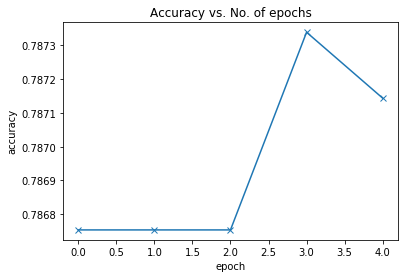

In [50]:
plot_accuracies(history)

In [51]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

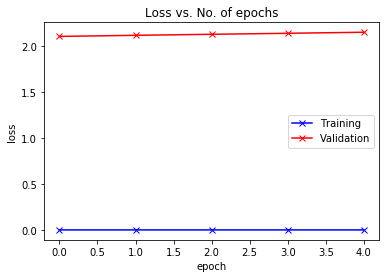

In [52]:
plot_losses(history)

# Testing with individual Images

In [53]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [54]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


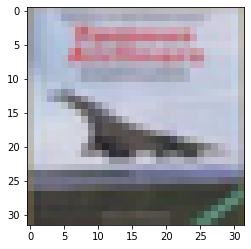

In [55]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


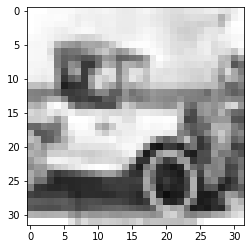

In [56]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


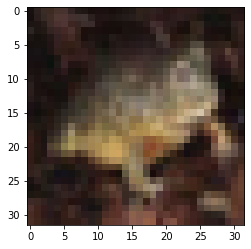

In [57]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [58]:
 test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 2.132462501525879, 'val_acc': 0.783886730670929}

# Saving and Loading the Model

In [59]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [60]:
model2 = to_device(Cifar10CnnModel(), device)

In [61]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [62]:
evaluate(model2, test_loader)

{'val_loss': 2.132462501525879, 'val_acc': 0.783886730670929}